In [1]:
%matplotlib inline
import matplotlib.pyplot as plt


import os
import itertools
import json
import numpy as np
import pandas as pd
import pickle
import requests
import seaborn as sns
import collections
from collections import Counter
import scipy
import time

import matplotlib as mpl
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition.pca import PCA


import nltk
#nltk.download('wordnet')
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
import gensim
import re
from fuzzywuzzy import process


/Users/stefgarasto/miniconda3/envs/nlp/lib/python3.6/site-packages/smart_open/ssh.py:34: UserWarning: paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress
  warnings.warn('paramiko missing, opening SSH/SCP/SFTP paths will be disabled.  `pip install paramiko` to suppress')


In [2]:
from utils_nos import nesta_colours, nesta_colours_combos
print(nesta_colours, nesta_colours_combos)

[[1, 0.7215686274509804, 0.09803921568627451], [1, 0, 0.2549019607843137], [0, 0, 0], [1, 0.35294117647058826, 0], [0.6078431372549019, 0, 0.7647058823529411], [0.6470588235294118, 0.5803921568627451, 0.5098039215686274], [0.6274509803921569, 0.5686274509803921, 0.1568627450980392], [0.7686274509803922, 0.6901960784313725, 0], [0.9647058823529412, 0.49411764705882355, 0], [0.7843137254901961, 0.1568627450980392, 0.5725490196078431], [0.23529411764705882, 0.07058823529411765, 0.3215686274509804]] [[0, 1, 2, 3, 4, 5], [0, 6, 7], [1, 3, 8], [4, 9, 10], [8, 5], [1, 11]]


In [3]:
# set up plot style
print(plt.style.available)
plt.style.use(['seaborn-darkgrid','seaborn-poster','ggplot'])

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


#### TODOs for data cleaning:

1. remove square brackets
2. make everything lower case


## Overview

This notebook contains a few functions and snippets of code that are useful for analysing text. Most of the techniques used are unsupervised. Functions are defined up front and then used in sections below.

This notebook is to apply:
- Tokenizers (based on n-grams and 'as_is')
- LSH

This specific instance of the notebook will be applied to the analysis of NOS


In [4]:
# flatten lists of lists
def flatten_lol(t):
    return list(itertools.chain.from_iterable(t))
flatten_lol([[1,2],[3],[4,5,6]])


[1, 2, 3, 4, 5, 6]

In [5]:
#These two functions are useful for analysing bi and tri-grams with w2v models in gensim

def convert_to_undersc(skill):
    '''
    convert spaces in skill phrases into underscores to use with trained
    w2v model.
    '''
    if len(skill.split(' ')) >1:
        new_i = '-'.join(skill.split(' '))
    else:
        new_i = skill
    return(new_i)

def convert_from_undersc(skill):
    '''
    convert underscores between terms in skill phrases back to spaces.
    '''
    if len(skill.split('_')) >1:
        new_i = ' '.join(skill.split('_'))
    else:
        new_i = skill
    return(new_i)


In [6]:
#A few functions for tyding up text
def tag_for_lemmatise(s):
    pos_to_wornet_dict = {
        'JJ': 'a',
        'JJR': 'a',
        'JJS': 'a',
        'RB': 'r',
        'RBR': 'r',
        'RBS': 'r',
        'NN': 'n',
        'NNP': 'n',
        'NNS': 'n',
        'NNPS': 'n',
        'VB': 'v',
        'VBG': 'v',
        'VBD': 'v',
        'VBN': 'v',
        'VBP': 'v',
        'VBZ': 'v',
    }
    try:
        return pos_to_wornet_dict[nltk.pos_tag([s])[0][1]]
    except:
        return 'n'
    
def lemmatise(title_terms):
    """
    Takes list as input.
    Removes suffixes if the new words exists in the nltk dictionary.
    The purpose of the function is to convert plural forms into singular.
    Allows some nouns to remain in plural form (the to_keep_asis is manually curated).
    Returns a list.
    >>> lemmatise(['teachers'])
    ['teacher']
    >>> lemmatise(['analytics'])
    ['analytics']
    """
    keep_asis = ['sales', 'years', 'goods', 'operations', 'systems',
                    'communications', 'events', 'loans', 'grounds',
                    'lettings', 'claims', 'accounts', 'relations',
                    'complaints', 'services']
    wnl = nltk.WordNetLemmatizer()
    processed_terms = [wnl.lemmatize(i) if i not in keep_asis else i for i in title_terms]
    #processed_terms = [wnl.lemmatize(i, pos = tag_for_lemmatise(i)) 
    #            if i not in keep_asis else i for i in title_terms]
    return processed_terms

def remove_digits(s):
    """
    Takes a string as input.
    Removes digits in a string.
    Returns a string.
    >>> remove_digits('2 recruitment consultants')
    ' recruitment consultants'
    """
    result = ''.join(i for i in s if not i.isdigit())
    return result

def remove_list_enumeration(s):
    '''
    This is a specific requirement of the NOS that comes from
    the presence of lists enumerated by strings like K+number
    or P+number. Therefore, after "lowerising" and removing 
    digits, I look for and remove strings like "k " and "p "
    '''
    result = re.sub('( k )+',' ',s)
    result = re.sub('( p )+', ' ', result)
    # it might not be necessary if I add 'k' and 'p' to stopwords
    return result

select_punct = set('!"#$%&\()*+,-./:;<=>?@[\\]^_`{|}~') #only removed "'"
extra_chars = set('–-•’”“µ¾âãéˆﬁ[€™¢±ï…˜')
all_select_chars = select_punct.union(extra_chars)
def replace_punctuation(s):
    """
    Takes string as input.
    Removes punctuation from a string if the character is in select_punct.
    Returns a string.
   >>> replace_punctuation('sales executives/ - london')
   'sales executives   london'
    """
    for i in set(all_select_chars): #set(select_punct):
        if i in s:
            s = s.replace(i, ' ')
    return s

def tidy_desc(desc):
    clean_data = desc.replace('\r\n', '').replace('\xa0', '')
    nodigits = remove_digits(clean_data.lower())
    nopunct = replace_punctuation(nodigits)
    #nopunct = remove_list_enumeration(nopunct)
    lemm = lemmatise(nopunct.split())
    return ' '.join(lemm)

def tokenize(text):
    """
    Takes string as input.
    Returns list of tokens. The function is used as an argument for
    TfidfVectorizer.
    >>> tokenize('some job title')
    ['some', 'job', 'title']
    """
    tokens = nltk.word_tokenize(text)
    return tokens

def tokenize_asis(some_list):
    """
    Takes list as input.
    Returns the list with elements converted to lower case. The function is 
    used as an argument for TfidfVectorizer.
    
    In [57]: tokenize(['Accounting', 'Microsoft Excel'])
    Out[57]: ['accounting', 'microsoft excel']
    """
    tokens = [elem.lower() for elem in some_list]
    return tokens

In [7]:
#This set of functions is useful for identifying terms with highest tf-idf weights 
#in a single document or set of documents

def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding 
        feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25, sparse_output = False):
    ''' Return the top n features that on average are most important 
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    if sparse_output:
        return scipy.sparse.csr_matrix(top_tfidf_feats(tfidf_means, features, top_n))
    else:
        return top_tfidf_feats(tfidf_means, features, top_n)

def all_mean_feats(Xtr, grp_ids=None, min_tfidf=0.1):
    ''' Return the average
        amongst documents in rows
        indentified by indices in grp_ids. '''
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return tfidf_means

def get_top_words_weights(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words

def get_mean_tfidf(desc, vect):
    response = vect.transform(desc)
    tfidf_values = all_mean_feats(response, grp_ids = None)
    return tfidf_values

def get_top_words(desc, feature_names, vect, n = 25):
    response = vect.transform(desc)
    words = top_mean_feats(response, feature_names, grp_ids = None, top_n = n)
    return words['feature'].values

In [8]:
#Function to parse html

from html.parser import HTMLParser
class MyHTMLParser(HTMLParser):

#HTML Parser Methods
#Initializing lists
    lsData = list()
    
    def handle_data(self, data):
        self.lsData.append(data)
        
    def get_data(self):
        return ''.join(self.lsData)

           
def strip_tags(some_html):
    """
    Takes string as input.
    Removes html tags.
    Returns a string.
    """
    s = MyHTMLParser()
    s.lsData = list()
    s.feed(some_html)
    data = s.get_data()
    s.reset
    return data


In [9]:
def print_elapsed(t0_local, task = 'current task'):
    print('Done with {}. Elapsed time: {:4f}'.format(task,time.time()-t0_local))
    

In [10]:
qualifier = 'postjoining_final_no_dropped'
qualifier0 = 'postjoining_final_no_dropped'
pofs = 'n'


In [11]:
output_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/'


In [12]:
lookup_dir = '/Users/stefgarasto/Google Drive/Documents/results/NOS/extracted/'


In [13]:
#Loading a pre-trained glove model into gensim
from gensim.scripts.glove2word2vec import glove2word2vec

glove_dir = '/Users/stefgarasto/Local-Data/wordvecs/glove.twitter.27B'

# to make the glove model file compatible with gensim
#for dim in ['25','50','100','200']:
##    glove_file = os.path.join(glove_dir,'glove.twitter.27B.{}d.txt'.format(dim))
#    tmp_file = os.path.join(glove_dir, 'word2vec.glove.twitter.27B.{}d.txt'.format(dim) )
#    _ = glove2word2vec(glove_file, tmp_file)

LOADGLOVE = False
if LOADGLOVE:
    # load the glove model
    model = gensim.models.KeyedVectors.load_word2vec_format\
    (os.path.join(glove_dir, 'word2vec.glove.twitter.27B.100d.txt'))
    #model = api.load("glove-wiki-gigaword-100")  # load pre-trained word-vectors from gensim-data
    #model = Word2Vec(common_texts, size=100, window=5, min_count=1, workers=4)
    #word_vectors = model.wv
print('Done')


Done


In [14]:
#Get the NOS data for approved apprenticeship standards from api
#r2 = requests.get("https://www.instituteforapprenticeships.org/api/fullstandards/")
#df_api= pd.DataFrame(r2.json())
df_nos = pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}.zip'.format(qualifier0))

# load the cleaned and tokenised dataset
df_nos = df_nos.join(pd.read_pickle(lookup_dir + 'all_nos_input_for_nlp_{}_pruned_{}.zip'.format(qualifier,pofs)))
print('Done')


Done


In [15]:
# manually remove "k"s and "p"s from the pruned columns
def remove_pk(x):
    return [t for t in x if t not in ['k','p']]
df_nos['pruned'] = df_nos['pruned'].map(remove_pk)

In [16]:
df_nos.sample(n=3)


,Title,NOS Title,URN,Original URN,Overview,Knowledge_and_understanding,Performance_criteria,Scope_range,Glossary,Behaviours,...,All_suites,Relevant_occupations,notes,empty,extra_meta_info,Created,Path,pruned,clean_full_text,tagged_tokens
sfshib10.pdf,maintain the performance of the human identity...,maintain the performance of the human identity...,sfshib10,[HIB10],[This unit defines the national standard of oc...,[Provide proactive maintenance and support for...,[Provide proactive maintenance and support for...,[Provide proactive maintenance and support for...,NaN,NaN,...,[human identity and biometrics],[Elementary Occupations; Elementary Security O...,NaN,False,NaN,2014-03-31 18:05:38,publishednos-old,"[performance, identity, solution, maintenance,...",maintain the performance of the human identity...,"[(maintain, VB), (the, DT), (performance, NN),..."
impqi214sv1l.pdf,contribute to the development of standard oper...,contribute to the development of standard oper...,impqi214sv1,impqi,[This standard is about the skills needed for ...,[Contribute to the development of Standard Ope...,[Contribute to the development of Standard Ope...,NaN,NaN,NaN,...,[achieving food manufacturing excellence],[Manufacturing technologies; Food Preparation ...,NaN,False,"[v1, Contribute to the development of Standard...",2014-03-31 17:39:08,publishednos-old,"[contribute, development, procedure, sop, food...",contribute to the development of standard oper...,"[(contribute, NN), (to, TO), (the, DT), (devel..."
semme3057.pdf,loading and proving cnc fabrication machine to...,loading and proving cnc fabrication machine to...,semme3057,[],[This standard identifies the competences you ...,"[K1, K2, K3, K4, K5, K6, K7, K8, K9, K10, K11,...","[P1, P2, P3, P4, P5, P6, P7, P8, work safely a...",[1. Apply all of the following checks and prac...,NaN,NaN,...,[marine engineering suite 3],[Marine Engineering Trades],NaN,False,NaN,2014-03-31 17:51:56,publishednos-old,"[loading, fabrication, machine, tool, program,...",loading and proving cnc fabrication machine to...,"[(loading, NN), (and, CC), (proving, VBG), (cn..."


In [17]:
# Load stopwords
with open(lookup_dir + 'stopwords_for_nos_{}_{}.pickle'.format(qualifier,pofs),'rb') as f:
    stopwords0, no_idea_why_here_stopwords, more_stopwords = pickle.load(f)
stopwords = stopwords0 + no_idea_why_here_stopwords 
stopwords += tuple(['¤', '¨', 'μ', 'บ', 'ย', 'ᶟ', '‰', '©', 'ƒ', '°', '„'])
stopwords0 += tuple(['¤', '¨', 'μ', 'บ', 'ย', 'ᶟ', '‰', '©', 'ƒ', '°', '„'])


In [18]:
#df_nos[['NOS Title', 'URN', 'Clean SOC Code', 'One_suite']].rename(columns = {
#    'NOS Title': 'NOS Title', 'URN':'URN', 'Clean SOC Code': 'SOC Code', 'One_suite': 'Suite'
#}).to_csv(os.path.join(output_dir,'NOS_and_SOC_codes.csv'))

## LSH

In [19]:
from datasketch import MinHashLSHEnsemble, MinHash, MinHashLSH


In [20]:
def shingles(text, char_ngram=5):
    '''
    This function splits strings into continuous sets of characters of length n. In the current example n = 5.
    '''
    if len(text) == 5:
        res = set([text, text])
    else:
        res = set(text[head:head + char_ngram] \
               for head in range(0, len(text) - char_ngram))
    return res


In [21]:
t0 = time.time()
shingled_desc = [shingles(desc) for desc in df_nos['clean_full_text']]
print_elapsed(t0, 'splitting the text into groups of characters')


Done with splitting the text into groups of characters. Elapsed time: 34.911565


In [22]:
#Create hash signatures for shingles
t0 = time.time()
hash_objects = []
for i in range(len(shingled_desc)):
    m = MinHash(num_perm=200)
    hash_objects.append(m)
print_elapsed(t0, 'creating hash signatures')


Done with creating hash signatures. Elapsed time: 17.214881


In [23]:
SAVELSH = False


In [24]:
t0 = time.time()
for ix, desc in enumerate(shingled_desc):
    for d in desc:
        hash_objects[ix].update(d.encode('utf8'))
print_elapsed(t0, 'encoding hash objects')


Done with encoding hash objects. Elapsed time: 744.036693


In [25]:
content = []
standard_labels = list(df_nos.index.values) #df_nos['URN'].values)
title_labels = list(df_nos['NOS Title'].values)
urn_labels = list(df_nos['URN'].values)
for ix, desc in enumerate(shingled_desc):
    content.append((standard_labels[ix], hash_objects[ix]))
    

In [26]:
#Define LSH and Jaccard similarity threshold
LSH_th = 0.8
lsh = MinHashLSH(threshold=LSH_th, num_perm=200)


In [27]:
for ix,elem in enumerate(content):
    #lsh.insert('{}'.format(ix), elem[1]) #elem[0], elem[1])
    lsh.insert(elem[0], elem[1])
    

In [28]:
#For each standard search all signatures and identify potential clashes (e.g. other standards 
# with Jaccard similarity of shingle sets greater or equal to the threshold). 
# Note: some of the candidates might be false positives.
candidates = {}
singletons = []
candidates2 = []
for ix, desc in enumerate(shingled_desc):
    result = lsh.query(hash_objects[ix])
    if len(result) >1:
        full_result = []
        for res in result:
            full_result.append((urn_labels[standard_labels.index(res)
                                          ],df_nos['NOS Title'].loc[res],res))
        
        candidates[standard_labels[ix]] = full_result
        candidates2.append(result)
        if ix<40:
            print(urn_labels[ix], ': ', full_result)
            print('***************')
    else:
        singletons.append(standard_labels[ix])
        

fspaml13 :  [('fspaml13', 'advise and guide staff in your organisation on anti-money laundering and countering terrorist financing  ', 'advise-and-guide-staff-in-your-organisation-on-anti-money-laundering-and-countering-terrorist-financing-fspaml13.pdf'), ('fspaml13', 'advise and guide staff in your organisation on anti-money laundering and countering terrorist financing', 'fspaml13.pdf')]
***************
cosvr383 :  [('cosvr383', 'apply specialist pavement surfacing materials manually', 'cosvr383.pdf'), ('cosvr383', 'apply specialist pavement surfacing materials manually', 'apply-specialist-pavement-surfacing-materials-manually-cosvr383.pdf'), ('cosvr516', 'install self drilling ground anchors', 'cosvr516l.pdf'), ('cosvr401', 'set out secondary dimensional work control', 'cosvr401.pdf'), ('cosvr516', 'install self drilling ground anchors', 'cosvr516.pdf')]
***************
coglata3-04 :  [('coglata3-04', 'assess and communicate scientific or technical information to authorised personne

In [29]:
'''  
Alternative function to get matches and organise them in groups. (From Jyl's code)

def union_find(data):
    ''''''Create Disjoint Data Structure from list of lists''''''
    parents = {}
    def find(i):
        j = parents.get(i, i)
        if j == i:
            return i
        k = find(j)
        if k != j:
            parents[i] = k
        return k
    for l in filter(None, data):
        parents.update(dict.fromkeys(map(find, l), find(l[0])))
    merged = {}
    for k, v in parents.items():
        merged.setdefault(find(v), []).append(k)
    return list(merged.values())


candidates = []
for ix, skill_set in enumerate(skill_sets):
    result = lsh.query(hash_objects[ix])
#    if len(result) >1:
    candidates.append(result)

disjoint_candidates = union_find(candidates)

'''
print('to try')

to try


In [30]:
# Amount of NOS that found at least a match = total NOS - number of singletons
print('Nb. of NOS that were not matched with anything: {}'.format(len(singletons)))
print('Nb. of NOS that matched: {}'.format(len(title_labels) - len(singletons)))


Nb. of NOS that were not matched with anything: 15289
Nb. of NOS that matched: 7328


In [31]:

'''# If we make the assumptions that groups are closed and don't form chains, then:
# nb of groups of N = nb of matches of length N / N
all_lengths = np.array([len(t) for t in candidates2])
unique_lengths = list(set(all_lengths))
len_counts = []
for ln in unique_lengths:
    len_counts.append((ln,np.sum(all_lengths == ln)))
print(np.sum([t[1] for t in len_counts]))
print(len(candidates2),len(candidates))
print(len_counts)
'''
print('Done')

Done


In [32]:
Nmatched = len(title_labels) - len(singletons)
Adj_matrix = np.zeros((Nmatched,Nmatched))
np.sum(Adj_matrix)

0.0

Done with creating the adjacency matrix. Elapsed time: 0.186375
The highest degree in the adjacency matrix is:  282.0
The number of matched couples are:  3611


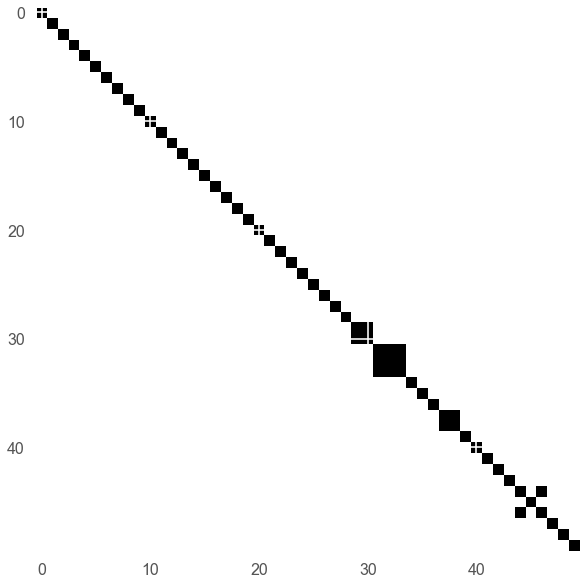

In [33]:
# I think that the first thing should be to create an adjacency matrix
t0 = time.time()
Nmatched = len(title_labels) - len(singletons)
Adj_matrix = np.zeros((Nmatched,Nmatched))
# create dictionary of indices
indices = {}
indices_reverse = {}
for ix, candidate in enumerate(candidates):
    indices[candidate] = ix
    indices_reverse[ix] = candidate
# now cycle again through the matched NOS and populate the adjacency matrix
for ix, candidate in enumerate(candidates):
    idx1 = ix
    for k in candidates[candidate]:
        # now this is a list of tuples, where the first element is the urn label
        idx2 = indices[k[2]]
        Adj_matrix[idx1,idx2] = 1

print_elapsed(t0,'creating the adjacency matrix')
plt.figure(figsize = (10,10))
plt.imshow(Adj_matrix[:50,:50])
print('The highest degree in the adjacency matrix is: ', np.max(np.sum(Adj_matrix,axis=1)))
print('The number of matched couples are: ', np.sum(np.sum(Adj_matrix, axis = 1)==2))


In [34]:
# group the NOS that were matched as similar
t0 = time.time()
matched_groups = []
matched_indices = []
for ix in range(Adj_matrix.shape[0]):
    idx_used = []
    # find the adjacent nodes
    where_list = list(np.where(Adj_matrix[ix])[0])
    where_list_cumul = []
    # don't go into the rabbit hole of nodes with very high degree - 
    # also, don't use indices already matched
    if len(where_list)<60000 and (ix not in matched_indices):
        for ix2 in where_list:
            # if the neighborhood has connections to indices that we haven't included yet, 
            # add them to the list to be analysed later
            where_list_cumul += list(np.where(Adj_matrix[ix2])[0])
            idx_used.append(ix2)
            # grow the neighbourhood by adding the new connections
            new_list = [t for t in where_list_cumul if t not in where_list]
            # don't go into the rabbit hole of nodes with very high degree
            if len(new_list)>60000:
                break # this one tells it to break the inner for cycle - 
                # it goes to the next "if (set(idx_used) == set(where_list))..."
            if len(new_list):
                # if the length is zero it means there are no new connected nodes
                where_list+=new_list
        # if it has never gone into a rabbit hole then add the group just found
        # if and only if the neighbourhood is self-contained, 
        # that is if the nodes for which we have collected the neighbours are the same
        # that appeared in the combined neighbourhoods
        if (set(idx_used) == set(where_list)) and (len(new_list)<6):
            if len(new_list)>6:
                print('got here after breaking for index', idx_used)
            matched_groups.append(tuple(idx_used))
            matched_indices += idx_used #[t for t in idx_used if t not in matched_indices]
print_elapsed(t0, 'grouping the similar NOS')


Done with grouping the similar NOS. Elapsed time: 126.097320


In [35]:
group_lengths = [len(t) for t in matched_groups]
group_lengths = Counter(group_lengths)
group_lengths.most_common()
print('Number of groups with different lengths')
print(sorted(group_lengths.items()))

Number of groups with different lengths
[(2, 1533), (3, 275), (4, 129), (5, 51), (6, 37), (7, 20), (8, 13), (9, 5), (10, 12), (11, 10), (12, 6), (13, 6), (14, 9), (15, 3), (16, 3), (17, 4), (18, 1), (19, 2), (21, 1), (22, 1), (23, 1), (24, 3), (26, 1), (28, 2), (29, 1), (30, 1), (38, 1), (39, 1), (40, 1), (45, 2), (46, 1), (900, 1)]


In [36]:
for group in matched_groups:
    if len(group)==40:
        for t in group:
            print(indices_reverse[t])
            #print(candidates[t])

semae3111.pdf
semae3113.pdf
semme3105.pdf
semme3114.pdf
semme3112.pdf
semme3115.pdf
semme3116.pdf
semme3120.pdf
semme3127.pdf
semme3130.pdf
semme3131.pdf
semme3132.pdf
semme3107.pdf
semme3111.pdf
semme3113.pdf
semme3117.pdf
semme3129.pdf
semme3108.pdf
semme3124.pdf
semme3125.pdf
semme3104.pdf
semme3119.pdf
semme3123.pdf
semme3126.pdf
semme3118.pdf
semme3122.pdf
semme3103.pdf
semme2043.pdf
semme3128.pdf
semme3109.pdf
semme2036.pdf
semme2037.pdf
semme2042.pdf
semme2044.pdf
semme2045.pdf
semme2038.pdf
semme2040.pdf
semme2039.pdf
semme2041.pdf
semme2046.pdf


In [37]:
#for t in matched_couples:
#    if not (t in matched_groups):
#        print(t)
# show some of the groups
groups_length = [len(t) for t in matched_groups]
print('Number of groups of size up to 3: ', np.sum([t<4 for t in groups_length]))
nbprint = 0
for t in matched_groups:
    if len(t)>4 and len(t)<7:
        print(t)
        for it in t:
            print(np.where(Adj_matrix[it])[0])
        nbprint+=1
    if nbprint>2:
        break


Number of groups of size up to 3:  1808
(13, 306, 3041, 3461, 3853)
[  13  306 3041 3461 3853]
[  13  306 3041 3461 3853]
[  13  306 3041 3461 3853]
[  13  306 3041 3461 3853]
[  13  306 3041 3461 3853]
(24, 2380, 2439, 3402, 3933, 258)
[  24 2380 2439 3402 3933]
[  24 2380]
[  24 2439 3402 3933]
[  24 2439 3402]
[  24  258 2439 3933]
[ 258 3933]
(36, 359, 3386, 3468, 3855, 6871)
[  36  359 3386 3468 3855 6871]
[ 36 359]
[  36 3386 3468 3855]
[  36 3386 3468]
[  36 3386 3855]
[  36 6871]


In [38]:
# check that all the groups are not overlapping: if it prints something is bad
print('If something gets printed next, then the groups indentified have overlaps')
matched_groups2 = []
for it,t in enumerate(matched_groups):
    if it>40000:
        break
    flag = 0
    for t2 in matched_groups:
        if t != t2:
            if set(t).intersection(set(t2)):
                print(t,t2)
                flag += 1
                #if (set(t)-set(t2)) and (set(t2) - set(t)):
                #    print(t,t2)
    if flag == 0:
        matched_groups2.append(t)
    else:
        print(flag)
        

If something gets printed next, then the groups indentified have overlaps


In [39]:
import copy
N = Adj_matrix.shape[0]
Nmatched= len(matched_indices)
print('number of grouped NOS', N, 'number of matched NOS', Nmatched)
# finally, check that the grouped and the non-grouped indices have a separate adjacency matrix
Adj_matrix2 = copy.deepcopy(Adj_matrix)
leftout_indices = list(set(range(N)) - set(matched_indices))
neworder_indices = np.array(matched_indices + leftout_indices)
# rearrange rows and columns of the adjacency matrix
Adj_matrix2 = Adj_matrix2[:, neworder_indices][neworder_indices]
print(''.join(['For the two parts of the Adjacency matrix to be separate, there has to',
               ' be no edges between the two.']))
print('The number of edges is: ')
print(np.sum(Adj_matrix2[:Nmatched,Nmatched:]))
# check the matrix is symmetric
print('if 1 the matrix is symmetric: ', np.mean(Adj_matrix2 == Adj_matrix2.T))


number of grouped NOS 7328 number of matched NOS 7328
For the two parts of the Adjacency matrix to be separate, there has to be no edges between the two.
The number of edges is: 
0.0
if 1 the matrix is symmetric:  1.0


In [40]:
print(leftout_indices)

[]


In [41]:
# now redo the dictionary to save, with placing the self-contained groups first 
# and then the unpaired ones
from collections import OrderedDict
candidates_grouped = OrderedDict()
candidates_paired = OrderedDict()

pair_counter = 0
group_counter = 0
for ix, group in enumerate(matched_groups):
    full_result = []
    if len(group)==2:
        for ig in group:
            res = indices_reverse[ig]
            full_result.append((urn_labels[standard_labels.index(res)
                                          ],df_nos['NOS Title'].loc[res],res))
        candidates_paired['Pair {}'.format(pair_counter)] = full_result
        pair_counter+=1
for ix, group in enumerate(matched_groups):
    full_result = []
    if len(group)>2:
        for ig in group:
            res = indices_reverse[ig]
            full_result.append((urn_labels[standard_labels.index(res)
                                          ],df_nos['NOS Title'].loc[res],res))
        candidates_grouped['Group {}'.format(group_counter)] = full_result
        group_counter+=1
    
#candidates_grouped['Finished with groups'] = '-'

'''# now add the ones that weren't matched
for ix in leftout_indices:
    res = indices_reverse[ig]
    candidates_grouped[res] = candidates[res]
'''
# try to save it, just to see what it looks like
## OBSOLETE ONES
#if SAVELSH and False:
#    tmp = pd.DataFrame.from_dict(candidates_grouped, orient = 'index')
#    print(tmp.columns)
#    tmp.to_csv(output_dir +  '/LSH_results_grouped_no_pairs_{}_th{}.csv'.format(
#                                                    qualifier,LSH_th))

#if SAVELSH and False:
#    pd.DataFrame.from_dict(candidates_paired, orient = 'index', columns = [
#                                                    'NOS 1','NOS 2']).to_csv(output_dir + 
#                                  '/LSH_results_paired_{}_th{}.csv'.format(qualifier,LSH_th))


"# now add the ones that weren't matched\nfor ix in leftout_indices:\n    res = indices_reverse[ig]\n    candidates_grouped[res] = candidates[res]\n"

In [42]:
output_dir

'/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/'

In [43]:
if SAVELSH and False:
    pd.DataFrame.from_dict(candidates, orient = 'index').to_csv(output_dir + '/LSH_results_{}_th{}.csv'.format(
        qualifier,LSH_th))
    with open(output_dir + '/Candidates_nos_{}_th{}.pickle'.format(qualifier,LSH_th),'wb') as f:
        pickle.dump(candidates,f)
        

TypeError: `Series.plot()` should not be called with positional arguments, only keyword arguments. The order of positional arguments will change in the future. Use `Series.plot(kind='barh')` instead of `Series.plot('barh',)`.

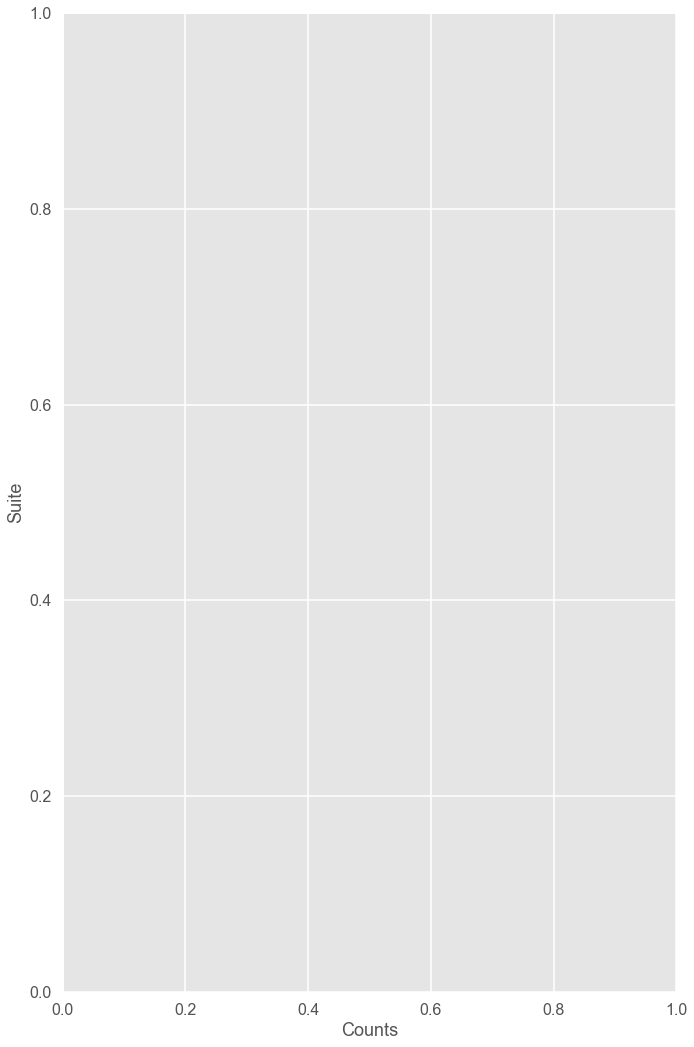

In [44]:
# Plot how many duplicates per suite / per originating organisation
# get the value count
def add_text_to_hist_new(values, xvalues = None, addval = None, orient = 'vertical'):
    if addval is None:
        addval = .5 + np.floor(2*np.log(max(values)))
    addx = -.2 if orient=='horizontal' else 0
    for ix,i in enumerate(values):
        if i>-1:
            if not xvalues:
                x = ix - .2
            else:
                x = xvalues[ix] +.02
            if orient == 'vertical':
                plt.text(i+addval, x, '{}'.format(i), fontsize = 14)
            else:
                plt.text(x, ix+addval,'{}'.format(i), fontsize = 14)
                
for col in ['One_suite', 'Developed By']:
    duplicated_suites = df_nos.loc[list(candidates.keys())][col].value_counts()
    all_suites = df_nos[col].value_counts()
    if col == 'One_suite':
        N = 70
        fig =plt.figure(figsize = (11,18))
        plt.ylabel('Suite',fontsize = 18)
    else:
        N = 32
        fig = plt.figure(figsize = (7,12))
        plt.ylabel('Developing organisation', fontsize = 18)
    plt.xlabel('Counts', fontsize = 18)
    with sns.plotting_context('talk'):
        duplicated_suites[:N][::-1].plot('barh', color = nesta_colours[3])
    ax = plt.gca()
    fig.canvas.draw()
    labels = [item.get_text().capitalize() for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels)
    plt.tight_layout()
    if SAVELSH:
        plt.savefig(os.path.join(output_dir,'{}_counts_for_duplicates.png'.format(col)))

    # now divide by the sum (so we get fractions)
    #duplicated_suites = duplicated_suites.map(lambda x: x/duplicated_suites.sum())
    #all_suites = all_suites.map(lambda x: x/all_suites.sum())
    # get the ratio of proportions with respect to the full distribution
    suites_ratio = {}
    abs_values = {}
    for row in all_suites.index[:N]:
        try:
            suites_ratio[row] = duplicated_suites.loc[row]/all_suites.loc[row]
            abs_values[row] = duplicated_suites.loc[row]
        except:
            suites_ratio[row] = 0
            abs_values[row] = 0
    suites_ratio = pd.DataFrame.from_dict(suites_ratio, orient = 'index', columns = ['ratio'])
    ## order by decreasing ratios 
    #suites_ratio= suites_ratio.sort_values(by='ratio', ascending = False)
    # plot the ratio
    if col == 'One_suite':
        fig=plt.figure(figsize = (12,18))
        ix = range(N)
        plt.ylabel('Suite',fontsize = 18)
    else:
        fig =plt.figure(figsize = (7,12))
        ix = range(N)
        plt.ylabel('Developing organisation', fontsize = 18)
    plt.xlabel('Proportion of NOS', fontsize = 18)
    plt.xlim([0,1])
    with sns.plotting_context('talk'):
        suites_ratio['ratio'].iloc[ix][::-1].plot('barh', color = nesta_colours[3])
    add_text_to_hist_new(list(abs_values.values())[::-1], xvalues = list(suites_ratio['ratio'].iloc[ix][::-1]), 
                         addval = -0.3, orient = 'horizontal')
    ax = plt.gca()
    fig.canvas.draw()
    labels = [item.get_text().capitalize() for item in ax.get_yticklabels()]
    ax.set_yticklabels(labels)
    plt.tight_layout()
    if SAVELSH:
        plt.savefig(os.path.join(output_dir,'{}_ratios_for_duplicates_{}.png'.format(col,LSH_th)))



In [45]:
output_dir

'/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/'

### Compute level of overlap for each group identified via the LSH algorithm
- Use the average level of pairwise overlap between NOS in each group


In [46]:
def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    res = float(intersection / union)
    return res

In [47]:
# this is just to assign keys and NOS to a dictionary - 
# so far they're in a list, so I can't easily find the MinHash corresponding to a given NOS

content_dict = {}
for ix,elem in enumerate(content):
    content_dict[elem[0]] = elem[1]
    
print(content_dict[lsh.query(elem[1])[0]].jaccard(content_dict[lsh.query(elem[1])[0]]))
print(lsh.query(elem[1]))

1.0
['write-text-based-material-for-multi-platform-use-sksj13.pdf']


909 3611 0.7482691775131542


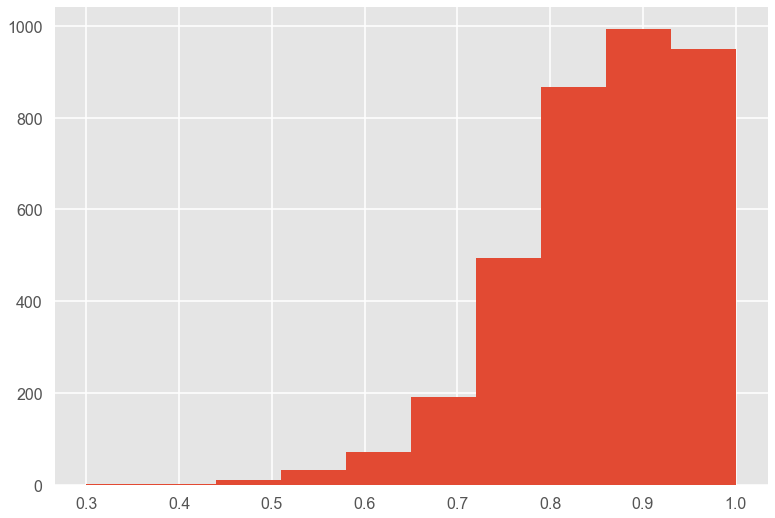

In [48]:
# just to show the precision of the LSH algorithm. # Just get the pairs of near duplicates 
# and compute the Jaccard similarity using the inbuil function
# Then check how many of these pairs actually do have Jaccard > LSH_th
pair_similarities = []
for ix, desc in enumerate(shingled_desc):
    result = lsh.query(hash_objects[ix])
    if len(result)==2:
        pair_similarities.append(content_dict[result[0]].jaccard(content_dict[result[1]]))
plt.hist(pair_similarities)
a = (np.array(pair_similarities)<LSH_th).sum()
b = len(pair_similarities)
print(a, b, 1-a/b)

In [49]:
# compute the average level of overlap within groups and compare to the average 
# number of common words
# candidates_grouped_new = copy.deepcopy(candidates_grouped)
#A = []
#B = []
all_j_values = []
all_w_values = []
t0 = time.time()
for ig,g in enumerate(candidates_paired.keys()):
    if g != 'Finished with groups':
        G = candidates_paired[g]
        j_values = []
        g_suites = []
        g_cat = []
        w_values = []
        
        for t,ix1 in enumerate(G):
            # create bag of words that retain duplicated words
            if len(G)<50:
                t1 = []
                for tt in df_nos.loc[ix1[2]]['clean_full_text'].split():
                    if tt not in t1:
                        t1.append(tt)
                    else:
                        t1.append(tt+'1')
            for ix2 in G[t+1:]:
                j_values.append(content_dict[ix1[2]].jaccard(content_dict[ix2[2]]))
                if len(G)<50:
                    # create bag of words that retain duplicates
                    t2 = []
                    for tt in df_nos.loc[ix2[2]]['clean_full_text'].split():
                        if tt not in t2:
                            t2.append(tt)
                        else:
                            t2.append(tt + '1')
                    w_values.append(len(set(t1).intersection(set(t2)))/ (len(set(t1)
                                                                        )+len(set(t2))) *2)
            g_suites.append(df_nos.loc[ix1[2]]['One_suite'])
            g_cat.append(df_nos.loc[ix1[2]]['NOSCategory'])
        
        if len(G)<50:
            # keep jaccard similarities
            all_j_values += j_values
            # keep proportion of common words
            all_w_values += w_values
        # append average jaccard similarity and number of unique suites in the group 
        # divided by groups size
        tmp = [t == 'generic' for t in g_cat]
    if ig%1000 == 999:
        print('Update. Time = {:.4f}s'.format(time.time()-t0))
print('Done in {:.4f}s'.format(time.time()-t0))
# print number of common words
#print(np.mean(np.array(all_w_values)[np.array(all_j_values)>0.9]))
#np.mean(all_w_values[np.array(all_j_values)>.9]))

Update. Time = 7.5618s
Done in 14.7172s


In [50]:
# compute the average level of overlap within groups bigger than two
candidates_grouped_new = copy.deepcopy(candidates_grouped)
candidates_grouped_string = {}
t0 = time.time()
for ig,g in enumerate(candidates_grouped.keys()):
    if g != 'Finished with groups':
        G = candidates_grouped[g]
        j_values = []
        g_suites = []
        g_cat = []
        w_values = []
        nos_strings = []
        for t,ix1 in enumerate(G):
            urn = ix1[0]
            title = ix1[1]
            nos_file = ix1[2]
            validity = df_nos.loc[nos_file]['Validity']
            status = df_nos.loc[nos_file]['Status']
            nos_strings.append('[{}] \"{}\" (\"{}\", {}, {})'.format(urn, title.capitalize(), nos_file, 
                                                                 validity.capitalize(),status.capitalize()))
            for ix2 in G[t+1:]:
                j_values.append(content_dict[ix1[2]].jaccard(content_dict[ix2[2]]))
        candidates_grouped_new[g] = [np.around(np.mean(j_values),3)] + G
        candidates_grouped_string[g] = [np.around(np.mean(j_values),3)] + nos_strings
    if ig%1000 == 999:
        print('Update. Time = {:.4f}s'.format(time.time()-t0))
print('First part done in {:.4f}s'.format(time.time()-t0))

#candidates_grouped_new.pop('Finished with groups')
# create the dataframe
tmp = pd.DataFrame.from_dict(candidates_grouped_string, orient = 'index').rename(columns = {0:'Avg group similarity'})
# rename the columns
rename_dict= {}
for ii in range(len(tmp.columns)):
    rename_dict[ii] = 'NOS {}'.format(ii)
tmp = tmp.rename(columns = rename_dict)
# sort by descending values of the average similarity
tmp = tmp.sort_values(by = 'Avg group similarity', ascending = False)
# rename the rows after the sorting
tmp = tmp.reset_index(drop=True)
rename_dict = {}
for ii in range(len(tmp)):
    rename_dict[ii] = 'Group {}'.format(ii)
tmp = tmp.rename(index = rename_dict)

# OFFICIAL ONE
if SAVELSH:
#   tmp = pd.DataFrame.from_dict(candidates_grouped_new, orient = 'index').rename(columns= {0:'Avg group similarity'})
    tmp.to_csv(output_dir + '/LSH_results_grouped_no_pairs_with_score_{}_th{}.csv'.format(qualifier,LSH_th))
print('All done in {:.4f}s'.format(time.time()-t0))

First part done in 3.6672s
All done in 4.1916s


#### Split large construction group into communities

In [ ]:
long_group =candidates_grouped_new['Group 0']
long_group = long_group[1:]


'''# recompute pairwise Jaccard similarities
j_values = np.zeros((len(long_group),len(long_group)))
#g_suites = []
#g_cat = []
#w_values = []
#nos_strings = []
for t,ix1 in enumerate(long_group):
    urn = ix1[0]
    title = ix1[1]
    nos_file = ix1[2]
    #validity = df_nos.loc[nos_file]['Validity']
    #status = df_nos.loc[nos_file]['Status']
    #nos_strings.append('[{}] \"{}\" (\"{}\", {}, {})'.format(urn, title.capitalize(), nos_file, 
    #                                                     validity.capitalize(),status.capitalize()))
    for _t,ix2 in enumerate(long_group[t+1:]):
        t2 = t+_t+1
        j_values[t,t2]  =content_dict[ix1[2]].jaccard(content_dict[ix2[2]])
j_values = j_values + j_values.T + np.identity(len(long_group))'''
print(long_group[:10])

In [63]:
for doc in long_group:
    doc_pdf = doc[2]
    near_duplicate_docs = candidates[doc_pdf]
    only_duplicate_docs = []
    for dupl_doc in near_duplicate_docs:
        if doc_pdf != dupl_doc[2]:
            only_duplicate_docs.append(dupl_doc)
    break

[('cosvr383', 'apply specialist pavement surfacing materials manually', 'cosvr383.pdf'), ('cosvr383', 'apply specialist pavement surfacing materials manually', 'apply-specialist-pavement-surfacing-materials-manually-cosvr383.pdf'), ('cosvr516', 'install self drilling ground anchors', 'cosvr516l.pdf'), ('cosvr401', 'set out secondary dimensional work control', 'cosvr401.pdf'), ('cosvr516', 'install self drilling ground anchors', 'cosvr516.pdf')]

[('cosvr383', 'apply specialist pavement surfacing materials manually', 'cosvr383.pdf'), ('cosvr516', 'install self drilling ground anchors', 'cosvr516l.pdf'), ('cosvr401', 'set out secondary dimensional work control', 'cosvr401.pdf'), ('cosvr516', 'install self drilling ground anchors', 'cosvr516.pdf')]


In [ ]:
import networkx as nx
from networkx.algorithms import community


In [ ]:
# community detection algorithm
t0 = time.time()
partition_lenghts = []
for th in [.7,.75,.8,.85]:
    graph_full = nx.from_numpy_matrix(j_values*(j_values>th))
    #nx.draw(graph_full)
    C = list(community.greedy_modularity_communities(graph_full))
    print(f'{time.time()-t0:.2f}')
    print('Is it a partition? ', community.is_partition(graph_full,C))
    partition_lenghts.append([len(c) for c in C])
    

In [ ]:
# show example group
c= C[0]
for t in c:
    print(long_group[t+1])
    

In [51]:
# compute the average level of overlap within pairs
candidates_paired_new = copy.deepcopy(candidates_paired)
candidates_paired_string = {}
t0 = time.time()
for ig,g in enumerate(candidates_paired.keys()):
    if g != 'Finished with groups':
        G = candidates_paired[g]
        j_values = []
        nos_strings = []
        for t,ix1 in enumerate(G):
            urn = ix1[0]
            title = ix1[1]
            nos_file = ix1[2]
            validity = df_nos.loc[nos_file]['Validity']
            status = df_nos.loc[nos_file]['Status']
            nos_strings.append('[{}] \"{}\" (\"{}\", {}, {})'.format(urn, title.capitalize(), nos_file, 
                                                                 validity.capitalize(), status.capitalize()))
            for ix2 in G[t+1:]:
                j_values = [content_dict[ix1[2]].jaccard(content_dict[ix2[2]])]
                if ig%30>-1:
                    if ix1[2]=='mpqmg31.pdf':
                        print(j_values,content_dict[ix1[2]] )
                    #print(ix1[2],ix2[2])
        candidates_paired_new[g] = [np.around(np.mean(j_values),3)] + G
        candidates_paired_string[g] = [np.around(np.mean(j_values),3)] + nos_strings
    if ig%1000 == 999:
        print('Update. Time = {:.4f}s'.format(time.time()-t0))
print('Done in {:.4f}s'.format(time.time()-t0))

#candidates_grouped_new.pop('Finished with groups')
# create the dataframe
tmp = pd.DataFrame.from_dict(candidates_paired_string, orient = 'index').rename(columns = {0:'Avg group similarity'})
# rename the columns
rename_dict= {}
for ii in range(len(tmp.columns)):
    rename_dict[ii] = 'NOS {}'.format(ii)
tmp = tmp.rename(columns = rename_dict)
# sort by descending values of the average similarity
tmp = tmp.sort_values(by = 'Avg group similarity', ascending = False)
# rename the rows after the sorting
tmp = tmp.reset_index(drop=True)
rename_dict = {}
for ii in range(len(tmp)):
    rename_dict[ii] = 'Pair {}'.format(ii)
tmp = tmp.rename(index = rename_dict)
if SAVELSH:
#   tmp = pd.DataFrame.from_dict(candidates_grouped_new, orient = 'index').rename(columns= {0:'Avg group similarity'})
    tmp.to_csv(output_dir + '/LSH_results_pairs_with_score_{}_th{}.csv'.format(qualifier,LSH_th))


[0.49] <datasketch.minhash.MinHash object at 0x1be2f29780>
Update. Time = 0.9032s
Done in 1.4128s


In [52]:
print('90%: ', np.mean(np.array(all_w_values)[np.array(all_j_values)>0.9]))
print('80%: ',np.array(all_w_values)[(np.array(all_j_values)>0.8) & (np.array(all_j_values)<0.9)].mean())

90%:  0.9740900880982742
80%:  0.9268130376522428


In [53]:
print(df_nos['clean_full_text'].map(lambda x: len(x.split())).mean())

750.2505637352434


In [ ]:
stop

## Hypothesis testing

In [ ]:
duplicated_nos = df_nos.loc[list(candidates.keys())]
duplicated_cos = duplicated_nos[duplicated_nos['Developed By']=='construction skills']
duplicated_nos = duplicated_nos[duplicated_nos['Developed By']=='semta']
tmp = list(duplicated_nos.index)
print([t for t in tmp if 'l' in t[-7:]])
print(duplicated_nos.columns)
print(duplicated_nos['Version_number'].value_counts())


In [ ]:
'''
# to be old and new updated nos, it would have to be the following conditions:
1. group of two NOS
2. two different versions (1 and higher)
3. same or very similar suite (that is, the same aside from numbers)
'''
semta_versions = []
mixed_version = []
semta_suites = []
semta_titles = []
for g in candidates_paired_new:
    group = candidates_paired_new[g]
    if group[1][0][:3]:# == 'sem':
        #print(len(group))
        semta_versions.append([])
        semta_suites.append([])
        semta_titles.append([])
        if len(group)==3:
            # only take groups of pairs
            for ix in range(1,len(group)):
                #print(duplicated_nos.loc[group[ix][2]]['Version_number'])
                try:
                    semta_versions[-1].append(duplicated_nos.loc[group[ix][2]][
                        'Version_number'])
                    semta_suites[-1].append(duplicated_nos.loc[group[ix][2]]['One_suite'])
                    semta_titles[-1].append(group[ix][1])
                except:
                    1
            if (1.0 in semta_versions[-1]) & ((2.0 in semta_versions[-1]) or (
                                                    3.0 in semta_versions[-1])):
                # check the suites
                suite1 = ''.join([t for t in semta_suites[-1][0] if not t.isdigit()])
                suite2 = ''.join([t for t in semta_suites[-1][1] if not t.isdigit()])
                title1 = semta_titles[-1][0]
                title2 = semta_titles[-1][1]
                out = process.extract(title1, [title2])
                out2 = process.extract(suite1, [suite2])
                # assume two titles are similar if the fuzzy matching is higher than 90
                if out[0][1]>79:
                    # if we also require the two suite names to have a match higher than 90
                    if out2[0][1]>79:
                        mixed_version.append(group)
                        print(semta_suites[-1][0],semta_suites[-1][1])
                        
print(semta_versions)
len(mixed_version), len(semta_versions), len(duplicated_nos)


In [ ]:
# construction skills should be responsible for the very big group
print(len(duplicated_cos))
for g in candidates_grouped_new:
    group = candidates_grouped_new[g]
    if group[1][0][:3] == 'cos':
        if len(group)>200:
            tmp = [group[ix][0][:3] for ix in range(1,len(group))]
            print(sum([t=='cos' for t in tmp]))


# Collecting data for visualisation

In [ ]:
import json
import networkx as nx
from xml.dom.minidom import parseString
from copy import deepcopy

In [ ]:
def get_one_soc(x):
    if isinstance(x,list):
        try:
            return x[0]
        except:
            return np.nan
    else:
        return x
    
def get_one_occupation(x):
    if isinstance(x,list):
        y= ''.join(x)
    else:
        y= x
    if isinstance(y,str):
        return y.split(';')
    else:
        return y
    

In [ ]:
# load duplicated NOS
if False:
    lshduplicate_file = ''.join(['/Users/stefgarasto/Google Drive/Documents/results/NOS/nlp_analysis/',
         'LSH_results_grouped_with_score_postjoining_final_no_dropped_th0.8.csv'])
    lshduplicate_nos = pd.read_csv(lshduplicate_file)


In [ ]:
if False:
    #%% process the LSH duplicates to assign group ID to NOS
    # NOTE: these are all the groups, not just engineering NOS
    def split_nos_in_groups(x):
        if isinstance(x,str):
            x = [t.strip() for t in x.replace(')','').replace('(','').replace('\'','').split(',')]
            return x[-1]
        else:
            return x
    tmp0 = lshduplicate_nos.applymap(split_nos_in_groups)
    df_nos_lsh = tmp0[['Unnamed: 0','Avg group similarity','1']]
    t0 = time.time()
    for i in range(2, len(lshduplicate_nos.columns)-2):
        tmp = tmp0[['Unnamed: 0','Avg group similarity','{}'.format(i)]].rename(columns = {'{}'.format(i):'1'})
        tmp = tmp[tmp['1'].notna()]
        df_nos_lsh = pd.concat([df_nos_lsh, tmp])
    print_elapsed(t0, 'assigning LSH groups to NOS')

    #%% Join LSH groups and transferable NOS
    df_nos2 = df_nos.join(df_nos_lsh.rename(columns = {'Unnamed: 0': 'lsh_group', 
                                                      'Avg group similarity': 'lsh_simil',
                                                      '1':'index'}).set_index('index'), how = 'left')
    df_nos2['lsh_group'].mask(df_nos2['lsh_group'].isnull(), 'na', inplace= True)
    # remove LSH groups with a low overall similarity
    #th_lsh = 0.75
    #df_nos2['lsh_group'].mask(df_nos2['lsh_simil']<th_lsh, 'na', inplace= True)

In [ ]:
#get the largest group
if False:
    df_group = df_nos2.groupby('lsh_group')[['Title','URN']].agg(len)
    largest_group_name = df_group.sort_values('Title').index[-2]
    # minus 2 because we don't want the 'na's


In [ ]:
# select the largest group and the relevant columns, then order it according to G
if False:
    metadata_cols = ['NOS Title', 'URN',
           'Originating_organisation','Date_approved_year',
           'Clean Ind Review Year', 'Version_number', 'Developed By', 'Validity',
           'Keywords', 'Clean SOC Code', 'NOS Document Status', 'NOSCategory', 'Occupations',
           'One_suite']
    largest_group = df_nos2[df_nos2['lsh_group']==largest_group_name][metadata_cols]
    # what's missing is to collect the Jaccard similarity among each pair of NOS in this largest group
    # get the old name
    for g in candidates_grouped:
        group = candidates_grouped[g]
        if len(group)>=len(largest_group):
            print(g,len(group),len(largest_group))
            break
    G = [standard for standard in group if standard[2] in largest_group.index]

    largest_group = largest_group.join(pd.DataFrame(np.arange(898), index = [standard[2] for standard in G],
                                                    columns = ['order']))
    largest_group = largest_group.sort_values(by = 'order')

In [ ]:
output_dir_viz = '/Users/stefgarasto/Google Drive/Documents/results/NOS/data_viz'

In [ ]:
# collect all similarities
if False:
    j_values = []
    g_suites = []
    g_cat = []
    w_values = []
    j_values_matrix = np.zeros((len(G),len(G)))
    t0 = time.time()
    for t1,ix1 in enumerate(G):
        j_values_matrix[t1,t1] = .5
        for t2,ix2 in enumerate(G):
            if t2<=t1:
                continue
            tmp_simil = content_dict[ix1[2]].jaccard(content_dict[ix2[2]])
            j_values.append(tmp_simil)
            j_values_matrix[t1,t2] = tmp_simil
        #candidates_grouped_new[g] = [np.around(np.mean(j_values),3)] + G
    print_elapsed(t0, 'computing similarities')
    # the matrix so far is TRIU - add the lower triangular bit to make it full
    j_values_matrix = j_values_matrix + j_values_matrix.T
    SAVEDATALSH = False
    if SAVEDATALSH:
        with open(os.path.join(output_dir_viz, 
                'data_from_largest_lsh_group_similarities.pickle'), 'wb') as f:
            pickle.dump((largest_group, j_values_matrix), f)
    #print(time.time() - t0)


## Compute a maximum spanning tree and use Gephi to get a good node layout

In [ ]:
if False:
    t0 = time.time()
    # create graph
    graph_full = nx.from_numpy_matrix(j_values_matrix)
    # assign labels
    new_labels = dict(zip(range(len(G)),largest_group.index))
    graph_full = nx.relabel_nodes(graph_full, new_labels)
    print_elapsed(t0,'creating and relabelling graph')


In [ ]:
# create maximum spanning tree
if False:
    t0 = time.time()
    graph_tree = nx.maximum_spanning_tree(graph_full)
    print_elapsed(t0,'getting max spanning tree')


In [ ]:
# save as gexf
if False:
    nx.write_gexf(graph_tree, os.path.join(output_dir_viz, 
                'max_tree_largest_group.gexf'))

    #pos = nx.random_layout(graph_full)
    #nx.draw_networkx_edge_labels(graph_full, pos)

In [ ]:
proceed_after_gephi = True

## Only AFTER changing the layout in Gephi

In [ ]:

if not proceed_after_gephi:
    stop
    
#node = tree.getElementsByTagName('node')[0].getElementsByTagName('attvalue')
#print(node[0].attributes.items())
#print(nodes.getElementsByTagName('attvalue')[0].attributes.items())#getElementsByTagName('attvalue'))
#print(nodes.getElementsByTagName('attvalue')[2].attributes.items())

In [ ]:
#pos = nx.planar_layout(graph_tree)
#nx.draw(graph_tree, pos)
# read the new gexf layout
#graph_tree2 = nx.read_gexf(os.path.join(output_dir_viz,'largest_group_tree_layout_with_force_atlas2.gexf'))
if False:
    pos_dict ={}
    # pase the gmxf file and save the position

    with open(os.path.join(output_dir_viz,'largest_group_tree_layout_with_force_atlas2_2.gexf'),
              'r') as f:
        tree = parseString(f.read())

    nodes = tree.getElementsByTagName('node')
    for node in nodes:
        k =node.getAttribute('id')
        pos_dict[k] = {}
        # to get the degree
        pos_tree= node.getElementsByTagName('attvalue')
        for value in pos_tree:
            pos_values = value.attributes.items()
            pos_dict[k][pos_values[0][1]] = pos_values[1][1]

        # to get the position
        pos_tree = node.getElementsByTagName('viz:position')
        pos_values = pos_tree[0].attributes.items()
        for att in pos_values:
            pos_dict[k][att[0]] = float(att[1])

        # to get the size
        pos_tree = node.getElementsByTagName('viz:size')
        pos_dict[k]['size']= pos_tree[0].attributes.items()[0][1]

        # to get the colour (synonym of community I think)
        pos_tree = node.getElementsByTagName('viz:color')
        pos_values = pos_tree[0].attributes.items()
        pos_dict[k]['color']= 'rbg({},{},{})'.format(pos_values[0][1],pos_values[1][1],pos_values[2][1])

    # turn the dict into a dataframe
    pos_df = pd.DataFrame.from_dict(pos_dict,orient='index')

In [ ]:
if False:
    pos_df.sample(n=2)

In [ ]:
# join with the original dataframe
if False:
    largest_group_with_pos = largest_group.join(pos_df)

In [ ]:
if False:
    largest_group_with_pos.sample(n=3)

In [ ]:
# now extract edges information
if False:
    with open(os.path.join(output_dir_viz,'largest_group_tree_layout_with_force_atlas2_2.gexf'),
              'r') as f:
        tree = parseString(f.read())
    edges_weights = pd.read_csv(''.join(['/Users/stefgarasto/Google Drive/Documents/results/NOS/',
                                         'data_viz/largest_group_tree_layout_with_force_atlas_weights2_3.csv']))
    edges = tree.getElementsByTagName('edge')
    edges_dict = {}
    #{"source":"n6","target":"n51","id":"212","attributes":{},"color":"rgb(36,129,178)","size":0.06302209943532944}
    for edge in edges:
        edge_values = edge.attributes.items()
        k = edge_values[0][1] #k=id
        edges_dict[k] = {}
        for val in edge_values[1:]:
            if val[0] == 'weight':
                edges_dict[k]['size'] = val[1]
            else:
                edges_dict[k]['old_'+val[0]] = val[1]
        # to get the colour (synonym of community I think)
        pos_tree = edge.getElementsByTagName('viz:color')
        pos_values = pos_tree[0].attributes.items()
        edges_dict[k]['color'] = 'rbg({},{},{})'.format(pos_values[0][1],pos_values[1][1],pos_values[2][1])
        # turn source/target into nID
        # get size = weight from pandas csv
        if 'size' not in edges_dict[k]:
            tmp = edges_weights[edges_weights['Id'] == int(k)]['Weight'].values[0]
            edges_dict[k]['size'] = tmp
    print('Done')


### Turn into json

In [ ]:
# template to copy
if False:
    file_name= ''.join(['/Users/stefgarasto/Google Drive/Documents/results/NOS/data_viz/',
                       'data_supply_chain_suite.json'])
    with open(file_name,'r') as f:
        supply_chain_json = json.load(f)
    print(supply_chain_json['nodes'][0].keys())#['attributes'])
    print(supply_chain_json['nodes'][0]['attributes'])
    for ix in range(2):
        print(supply_chain_json['nodes'][0]['size'])
    print(supply_chain_json['nodes'][0]['color'])
    A = [t['color'] for t in supply_chain_json['nodes']]
    print('colors for nodes' ,collections.Counter(A))
    print()
    A = [t['color'] for t in supply_chain_json['edges']]
    print('colors for edges' ,collections.Counter(A))
    print()
    A = [t['size'] for t in supply_chain_json['edges']]
    print('nb of sizes for edges' , len(collections.Counter(A)))
    print(supply_chain_json['edges'][0].keys())

In [ ]:
def get_keywords_list(x):
    #all_keywords = []
    #x = df_line['Keywords']
    if isinstance(x, list):
        # I think that ik can be a collection of words separated by ";" or ","
        ik_elems0 = ' '.join([elem for elem in x if not elem.isdigit()])
        ik_elems0 = ik_elems0.replace('-', ' ').replace(':','').replace(',',';')
        ik_elems0 = ik_elems0.replace('(','').replace(')','')
        ik_elems0 = ik_elems0.split(';')
        # remove extra spaces and make lowercase
        ik_elems0 = [elem.strip().lower() for elem in ik_elems0]
        ik_elems0 = [elem for elem in ik_elems0 if len(elem)]
        ik_elems = []
        for ik_elem in ik_elems0:
            ik_elem0 = ' '.join([elem for elem in ik_elem.split() if
                  (not elem.isdigit()) & (elem not in stopwords) & len(elem)])
            if len(ik_elem0):
                ik_elems.append(ik_elem0)
                    #print(ik_elems)
        return [elem.strip() for elem in ik_elems if len(elem)]
    elif isinstance(x,str):
        #ik_elems = re.findall(r"[\w']+", df.loc[ix].replace('-',''))
        ik_elems = x.replace('-', ' ').replace(',',';')
        ik_elems = ik_elems.replace('(','').replace(')','').split(';')
        if len(ik_elems)==1:
            # lacking proper separators - have to use spaces
            ik_elems = ik_elems[0].split()
        # remove extra spaces
        ik_elems = [elem.strip().lower().replace('\n','') for elem in ik_elems]
        # remove digits
        ik_elems = [elem for elem in ik_elems if not elem.isdigit()]
        ik_elems = [elem for elem in ik_elems if len(elem)>1]
        return [elem.strip() for elem in ik_elems if len(elem)]

In [ ]:
# first, create a dictionary
if False:
    attributes_dict= {'year_developed': 'Date_approved_year', 
                      'year': 'Date_approved_year', #,'keywords': 'Keywords' #'Clean Ind Review Year', 
                      'organisation': 'Developed By', 'title': 'NOS Title'}
    output_dict = {'nodes':[], 'edges': []}
    nodes_id_dict = {}
    for ix,node in enumerate(largest_group_with_pos.index):
        tmp_dict = {}
        row = largest_group_with_pos.loc[node]
        tmp_dict['label'] = row['URN'] #node
        for label in ['x','y']:
            tmp_dict[label] = row[label]
        tmp_dict['id'] = 'n{}'.format(ix)
        tmp_dict['degree'] = row['degree']
        tmp_dict['color'] = row['color']#'rgb(36,129,178)'
        tmp_dict['size']= 10.0
        tmp_dict['attributes'] = {}
        tmp_dict['attributes']['id'] = '{}'.format(ix)
        for attribute in attributes_dict.keys():
            tmp_dict['attributes'][attribute] = row[attributes_dict[attribute]]
            if isinstance(tmp_dict['attributes'][attribute], float):
                if np.isnan(tmp_dict['attributes'][attribute]):
                    tmp_dict['attributes'][attribute] = ''
        # extract and add keywords
        tmp_dict['keywords'] = get_keywords_list(row['Keywords'])
        if not tmp_dict['keywords']:
            print(tmp_dict['keywords'],type(tmp_dict['keywords']))
        #try:
        #    tmp_dict['attributes']['year'] = str(int(tmp_dict['attributes']['year']))
        #except:
        #    tmp_dict['attributes']['year'] = ''
        tmp_dict['attributes']['year_developed'] = tmp_dict['attributes']['year']
        #try:
        #    tmp_dict['attributes']['year_developed'] = str(int(tmp_dict['attributes'
        #                                                           ]['year_developed']))
        #except:
        #    pass
        tmp_dict['attributes']['file_name'] = node
        output_dict['nodes'].append(tmp_dict)
        # save the relationship label to id created here
        nodes_id_dict[node] = tmp_dict['id']

    # now add the edges
    for edge_id in edges_dict.keys():
        edge = copy.deepcopy(edges_dict[edge_id])
        edge['id'] = edge_id
        # transform the source/target from title to id
        edge['source'] = nodes_id_dict[edge['old_source']]
        edge['target'] = nodes_id_dict[edge['old_target']]
        edge['attributes'] = {}
        edge.pop('old_source')
        edge.pop('old_target')
        output_dict['edges'].append(edge)

In [ ]:
if False:
    print(output_dict['nodes'][:5])
    print()
    print(output_dict['edges'][:5])

In [ ]:
# save the json
SAVEJSON= False
if SAVEJSON:
    with open(os.path.join(output_dir_viz, 'max_tree_largest_group.json'), 'w') as fp:
        json.dump(output_dict, fp)

In [ ]:
#largest_group_with_pos['Clean Ind Review Year'].value_counts()

# Create clickable list of duplicates

### TODOs:
1. Test the transfer Mac to Windows with the new strategy.

    a. try removing asterisks from file names and using jsons instead of .txts    
    b. try removing asterisks from file names while still using 


In [ ]:
# create a dataframe of duplicates
duplicates_names = []
duplicates_info = {}
for pair_id in candidates_paired:
    pair = candidates_paired[pair_id]
    # get names
    for standard in pair:
        #print(standard)
        duplicates_names.append(standard[2])
        duplicates_info[standard[2]] = {}
        duplicates_info[standard[2]]['title'] = standard[1]
        duplicates_info[standard[2]]['URN'] = standard[0]
        duplicates_info[standard[2]]['suite'] = df_nos.loc[standard[2]]['One_suite']
        duplicates_info[standard[2]]['pair'] = 1
        duplicates_info[standard[2]]['pair_id'] = pair_id
        duplicates_info[standard[2]]['category'] = df_nos.loc[standard[2]]['NOSCategory']
        duplicates_info[standard[2]]['validity'] = df_nos.loc[standard[2]]['Validity']
        duplicates_info[standard[2]]['status'] = df_nos.loc[standard[2]]['Status']
print('Done with pairs')
for pair_id in candidates_grouped:
    pair = candidates_grouped[pair_id]
    # get names
    for standard in pair:
        #print(standard)
        duplicates_names.append(standard[2])
        duplicates_info[standard[2]] = {}
        duplicates_info[standard[2]]['title'] = df_nos.loc[standard[2]]['NOS Title'] #standard[1]
        duplicates_info[standard[2]]['URN'] = standard[0]
        duplicates_info[standard[2]]['suite'] = df_nos.loc[standard[2]]['One_suite']
        duplicates_info[standard[2]]['pair'] = 0
        duplicates_info[standard[2]]['pair_id'] = pair_id
        duplicates_info[standard[2]]['category'] = df_nos.loc[standard[2]]['NOSCategory']
        duplicates_info[standard[2]]['validity'] = df_nos.loc[standard[2]]['Validity']
        duplicates_info[standard[2]]['status'] = df_nos.loc[standard[2]]['Status']
print('Done')

# eliminate any nan:
for k in duplicates_info:
    for inner_k in duplicates_info[k]:
        if isinstance(duplicates_info[k][inner_k],float):
            if np.isnan(duplicates_info[k][inner_k]):
                duplicates_info[k][inner_k] = 'NA'

print('Done with removing nans')

In [ ]:
duplicates_df = pd.DataFrame.from_dict(duplicates_info, orient = 'index')
# group them by suite
duplicates_groupby = duplicates_df.groupby('suite')

In [ ]:
output_dir_viz2 = '/Users/stefgarasto/Local-Data'

In [ ]:
# WRITE THE SINGLE FILES AND THE LINKS SECTION OF THE MAIN HTML

# for each suite sort them alphabetically
txt_file = os.path.join(output_dir_viz2,'near_duplicates_list/duplicates_list_for_html_{}.txt'.format(
                                                                                file_type))
file_type = 'txt'
file_type_dirs = {'txt': 'duplicates_txts', 'json': 'duplicates_jsons'}
s_dir = file_type_dirs[file_type]
sub_dict= {}
with open(txt_file,'w') as f:
    for name,group in duplicates_groupby:
        #print(group)
        f.write('<p> <h3> Suite: \"{}\" </h3> </p>'.format(name.capitalize()))
        f.write('\n')
        group = group.sort_values('suite')
        for s_name,standard in group.iterrows():
            # Links section in the main html
            
            # version that write a file for each duplicate
            #s_name_json = os.path.splitext(s_name.replace(' ','+'))[0]
            #f.write('<p> [<a href="{}/{}.{}" target="_blank">\"{}\"</a>] \"{}\". </p>'.format(
            #    s_dir,s_name_json,file_type,standard['URN'],standard['title'].capitalize()))
            
            # version that writes a file for each group of duplicates
            s_name_json = duplicates_df.loc[s_name]['pair_id']
            #s_done_json = []
            f.write('<p> [<a href="{}/{}.{}" target="_blank">\"{}\"</a>] \"{}\". </p>'.format(
                s_dir,s_name_json,file_type,standard['URN'],standard['title'].capitalize()))
            f.write('\n')
            # get all duplicates and build the json/txt file
            sub_file_name = os.path.join(output_dir_viz2,'near_duplicates_list/{}/{}.{}'.format(
                                        s_dir,s_name_json,file_type))
            
            if standard['pair']:
                others= candidates_paired[standard['pair_id']]
            else:
                others = candidates_grouped[standard['pair_id']]
            # write the individual files
            with open(sub_file_name,'w') as subf:
                if file_type == 'txt':
                    subf.write('Potential near duplicates ({} in total). '.format(len(others)))
                    subf.write('\n')
                    subf.write('\n')
                elif file_type == 'json':
                    main_json_key = 'Potential near duplicates ({} in total)'.format(len(others))
                    sub_dict= {main_json_key: {}}
                else:
                    raise(ValueError)
                for ix,other in enumerate(others):
                    if file_type == 'txt':
                        try:
                            subf.write('{}. [\"{}\"] \"{}\". (\"{}\", \"{}\", \"{}\", \"{}\", \"{}\")'.format(
                                ix+1,other[0],other[1].capitalize(), 
                                duplicates_info[other[2]]['suite'].capitalize() ,other[2], 
                                duplicates_info[other[2]]['validity'].capitalize(), 
                                duplicates_info[other[2]]['status'].capitalize(),
                                duplicates_info[other[2]]['category'].capitalize()))
                        except:
                            subf.write('{}. [\"{}\"] \"{}\". (\"{}\", \"{}\", \"{}\", \"{}\", \"{}\")'.format(
                                ix+1,other[0],other[1].capitalize(), name.capitalize() ,other[2], 
                                duplicates_info[other[2]]['validity'].capitalize(), 
                                duplicates_info[other[2]]['status'].capitalize(),
                                duplicates_info[other[2]]['category'].capitalize()))
                        subf.write('\n')
                    elif file_type == 'json':
                        sub_dict[main_json_key]['Standard {}'.format(ix+1)] = {}
                        for json_key, json_value in zip(duplicates_info[other[2]].keys(),
                                                        duplicates_info[other[2]].values()):
                            if 'pair' in json_key:
                                continue
                            if json_key != 'URN':
                                json_value = str(json_value).capitalize()
                                json_key = json_key.capitalize()
                            sub_dict[main_json_key]['Standard {}'.format(ix+1)][json_key
                                                                   ] = json_value
                        sub_dict[main_json_key]['Standard {}'.format(ix+1)]['File name'] = other[2]
                    else:
                        raise(ValueError)
                json.dump(sub_dict,subf,separators=(',',': '), indent = 4)

print('Done')
#with open('logs/output.json', 'w') as outfile:
#     json.dump(json_data, outfile, indent=2, separators=(',', ': ')) 

In [ ]:
[[i*255 for i in t] for t in nesta_colours]

# Exploring transferable NOS

In [ ]:
engineering = ['aeronautical engineering suite 3', 'marine engineering suite 3',
       'explosive substances and articles', 'rail engineering',
       'automotive engineering suite 3',
       'mechanical manufacturing engineering suite 3 2008',
       'marine engineering suite 2',
       'polymer processing and related operations',
       'engineering maintenance suite 3 2008',
       'project control, estimating, planning and cost engineering',
       'engineering and manufacture suite 4',
       'engineering technical support suite 3 2009', 'down stream gas',
       'engineering maintenance in food manufacture',
       'land based engineering operations',
       'performing engineering operations suite 2',
       'engineering maintenance and installation suite 2 2008',
       'fabrication and welding engineering suite 3',
       'multi utility network construction',
       'mechanical manufacturing engineering suite 2 2008',
       'bus and coach engineering and maintenance',
       'aeronautical engineering suite 2', 'gas network construction',
       'building services engineering technology and project management',
       'fabrication and welding suite 2',
       'engineering toolmaking suite 3 2005',
       'electrical and electronic engineering suite 3',
       'engineering toolmaking suite 3',
       'performing engineering operations suite 1',
       'mechanical engineering services',
       'electrical and electronic servicing',
       'engineering woodworking, pattern and model making suite 3 2002',
       'engineering technical support suite 2 2007',
       'oil fired technical services', 'integrated systems engineering',
       'composite engineering suite 2', 'electricity network control engineer',
       'rail engineering signalling suite 3',
       'maintaining plant and systems electrical',
       'maintaining plant and systems instrument and controls',
       'rail engineering traction and rolling stock suite 3',
       'rail engineering telecoms suite 3', 'marine engineering',
       'maintaining plant and systems mechanical',
       'mechanical fire protection', 'grips and crane technicians',
       'engineering toolmaking level 3', 'air tightness testing',
       'plant operations extractives', 'utilities control centre operations',
       'rail engineering telecoms suite 2',
       'rail engineering signalling suite 2',
       'installing plant and systems small bore tubing occupations',
       'monitoring engineering construction activities',
       'heating and ventilating', 'refrigeration and air conditioning',
       'treatment processing and control in the water industry',
       'installing plant and systems mechanical',
       'supporting activities in engineering construction',
       'welding plate and pipework',
       'solar thermal photovoltaic panel installation and surveying',
       'rail engineering overhead line equipment construction suite 2',
       'plumbing and domestic heating',
       'rail engineering overhead line equipment construction suite 3',
       'installing plant and systems pipefitting', 'confined spaces',
       'rail engineering traction and rolling stock suite 2',
       'leakage detection and control', 'bulk explosive truck operations',
       'electrical and electronic engineering suite 3 2004',
       'installation, testing and commissioning of electrical systems and equipment plant',
       'mechanical ride operation',
       'electrotechnical services instrumentation',
       'fabricating steel structures plating',
       'metal decking and stud welding occupations',
       'performing engineering operations suite 1 2006',
       'offshore wind and marine installation and commissioning',
       'electrotechnical services approved electrician status',
       'engineering surveying operations',
       'performing engineering operations suite 2 2006',
       'land based operations', 'welding pipework',
       'composite engineering suite 3']

In [ ]:
df_nos['NOSCategory'].value_counts()

In [ ]:
#A = df_nos[df_nos['NOS Title'].map(lambda x : 'research' in x)]
A = df_nos.loc[list(candidates.keys())]
A = A[A['NOS Title'].map(lambda x : 'assist in' in x)]

In [ ]:
A['NOSCategory'].value_counts()

In [ ]:
A[A['NOSCategory']=='job specific'][['NOS Title','One_suite','tagged_tokens']]

In [ ]:
for k in candidates['semret215.pdf']:
    print(k[1])
    print(df_nos['One_suite'].loc[k[2]])
    

In [ ]:
A.index

In [ ]:
counter = 0
for k in candidates_paired:
    all_suites = []
    in_engineering = []
    for p in candidates_paired[k]:
        all_suites.append(df_nos['One_suite'].loc[p[2]])
        in_engineering.append(all_suites[-1] in engineering)
    if len(set(all_suites))>1:
        out = process.extract(all_suites[0],all_suites[1:])
        if (out[0][1]<80) and sum(in_engineering):
            print(k, candidates_paired[k])#[k][0][1], p[1])
            counter+=1
    #if k == 'Pair 104':
    #    print(candidates_paired[k])
    #if counter>25:
    #    break
print(counter)
print('*'*70)
counter2 = 0
for k in candidates_paired:
    all_suites = []
    in_engineering = []
    for p in candidates_paired[k]:
        all_suites.append(df_nos['One_suite'].loc[p[2]])
        in_engineering.append(all_suites[-1] in engineering)
    if len(set(all_suites))>1:
        out = process.extract(all_suites[0],all_suites[1:])
        if (out[0][1]>80) and sum(in_engineering):
            print(k, candidates_paired[k])#[k][0][1], p[1])
            counter2+=1

In [ ]:
df_nos.loc['cfabes004.pdf']


In [ ]:
    #pos_from_viz = [t for t in node.toxml().split('<viz:') if t[:8]=='position'][0] 
    ##node.toxml().split('<viz:position')[2]
    #pos_from_viz = pos_from_viz.split()
    #print(pos_from_viz)
    #tmp = re.findall('[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?',pos_from_viz[1])
    #if '-' in pos_from_viz[1]:
    #    pos_dict[k]['x'] = -float(tmp[0][0])
    #else:
    #    pos_dict[k]['x'] = float(tmp[0][0])
    #tmp = re.findall('[+-]?(\d+(\.\d*)?|\.\d+)([eE][+-]?\d+)?',pos_from_viz[2])
    #if '-' in pos_from_viz[2]:
    #    pos_dict[k]['y'] = -float(tmp[0][0])
    #else:
    #    pos_dict[k]['y'] = float(tmp[0][0])
    #break
#print(node.toxml())
